In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import scipy.ndimage
import matplotlib.pyplot as plt
import glob
import re
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from sklearn.decomposition import PCA
from time import time
import math

In [2]:
# constants

data = '/kaggle/dev/data-science-bowl-2017-data/'
stage1 = '/kaggle/dev/data-science-bowl-2017-data/stage1/'
sample_images = '/kaggle/dev/data-science-bowl-2017-data/sample_images/'
labels = '/kaggle/dev/data-science-bowl-2017-data/stage1_labels.csv'
stage1_processed = '/kaggle/dev/data-science-bowl-2017-data/stage1_processed/'
stage1_features = '/kaggle/dev/data-science-bowl-2017-data/stage1_features_mx/'
stage1_submission = '/kaggle/dev/data-science-bowl-2017-data/stage1_sample_submission.csv'
naive_submission = '/kaggle/dev/jovan/data-science-bowl-2017/data-science-bowl-2017/submissions/naive_submission.csv'

In [3]:
sample_ids = []

for d in os.listdir(sample_images):
    sample_ids.append(d)
    print("Patient '{}' has {} scans".format(d, len(os.listdir(sample_images + d))))

print('----')
print('Total patients {} Total DCM files {}'.format(len(os.listdir(stage1)), 
                                                      len(glob.glob(stage1 + '*/*.dcm'))))

Patient '0c98fcb55e3f36d0c2b6507f62f4c5f1' has 180 scans
Patient '0d19f1c627df49eb223771c28548350e' has 183 scans
Patient '0c37613214faddf8701ca41e6d43f56e' has 164 scans
Patient '0d2fcf787026fece4e57be167d079383' has 126 scans
Patient '0a38e7597ca26f9374f8ea2770ba870d' has 110 scans
Patient '00cba091fa4ad62cc3200a657aeb957e' has 134 scans
Patient '0d941a3ad6c889ac451caf89c46cb92a' has 177 scans
Patient '0a0c32c9e08cc2ea76a71649de56be6d' has 133 scans
Patient '0c60f4b87afcb3e2dfa65abbbf3ef2f9' has 136 scans
Patient '0c9d8314f9c69840e25febabb1229fa4' has 221 scans
Patient '0ca943d821204ceb089510f836a367fd' has 147 scans
Patient '0b20184e0cd497028bdd155d9fb42dc9' has 196 scans
Patient '0c0de3749d4fe175b7a5098b060982a1' has 123 scans
Patient '0c59313f52304e25d5a7dcf9877633b1' has 244 scans
Patient '0bd0e3056cbf23a1cb7f0f0b18446068' has 280 scans
Patient '0de72529c30fe642bc60dcb75c87f6bd' has 113 scans
Patient '0ddeb08e9c97227853422bd71a2a695e' has 171 scans
Patient '0a099f2549429d29b32f34

In [4]:
print("Analysis will be done on:")
scan_segmented_lungs_fill = {}

for sample_id in sample_ids:
    scans = np.load(stage1_processed + 'scan_segmented_lungs_fill_' + sample_id + '.npy')
    scan_segmented_lungs_fill[sample_id] = scans
    print('Patient {}: scans shape: {}'.format(sample_id, scans.shape))

Analysis will be done on:
Patient 0c98fcb55e3f36d0c2b6507f62f4c5f1: scans shape: (360, 350, 350)
Patient 0d19f1c627df49eb223771c28548350e: scans shape: (366, 370, 370)
Patient 0c37613214faddf8701ca41e6d43f56e: scans shape: (328, 360, 360)
Patient 0d2fcf787026fece4e57be167d079383: scans shape: (315, 310, 310)
Patient 0a38e7597ca26f9374f8ea2770ba870d: scans shape: (275, 320, 320)
Patient 00cba091fa4ad62cc3200a657aeb957e: scans shape: (335, 306, 306)
Patient 0d941a3ad6c889ac451caf89c46cb92a: scans shape: (354, 259, 259)
Patient 0a0c32c9e08cc2ea76a71649de56be6d: scans shape: (332, 340, 340)
Patient 0c60f4b87afcb3e2dfa65abbbf3ef2f9: scans shape: (272, 330, 330)
Patient 0c9d8314f9c69840e25febabb1229fa4: scans shape: (398, 309, 309)
Patient 0ca943d821204ceb089510f836a367fd: scans shape: (294, 300, 300)
Patient 0b20184e0cd497028bdd155d9fb42dc9: scans shape: (353, 360, 360)
Patient 0c0de3749d4fe175b7a5098b060982a1: scans shape: (308, 355, 355)
Patient 0c59313f52304e25d5a7dcf9877633b1: scans sha

### Post processing data for inception model

In [5]:
def img_to_rgb(im):
    w, h = im.shape
    ret = np.empty((w, h, 3), dtype=np.uint8)
    ret[:, :, 0] = im
    ret[:, :, 1] = im
    ret[:, :, 2] = im
    return ret

# Convert grayscale scans to rgb
# (num_scans, w, h) -> (num_scans, w, h, 3)
def scans_to_rgb(scans):
    num_scans, w, h = scans.shape
    reshaped_scans = np.empty((num_scans, w, h, 3), dtype=np.uint8)
    for scn in enumerate(scans):
        reshaped_scans[scn[0]] = img_to_rgb(scn[1])
    return reshaped_scans

In [6]:
for sample_id in sample_ids:
    print(scan_segmented_lungs_fill[sample_id].shape)
    scan_segmented_lungs_fill[sample_id] = scans_to_rgb(scan_segmented_lungs_fill[sample_id])
    print(scan_segmented_lungs_fill[sample_id].shape)

(360, 350, 350)
(360, 350, 350, 3)
(366, 370, 370)
(366, 370, 370, 3)
(328, 360, 360)
(328, 360, 360, 3)
(315, 310, 310)
(315, 310, 310, 3)
(275, 320, 320)
(275, 320, 320, 3)
(335, 306, 306)
(335, 306, 306, 3)
(354, 259, 259)
(354, 259, 259, 3)
(332, 340, 340)
(332, 340, 340, 3)
(272, 330, 330)
(272, 330, 330, 3)
(398, 309, 309)
(398, 309, 309, 3)
(294, 300, 300)
(294, 300, 300, 3)
(353, 360, 360)
(353, 360, 360, 3)
(308, 355, 355)
(308, 355, 355, 3)
(305, 390, 390)
(305, 390, 390, 3)
(350, 340, 340)
(350, 340, 340, 3)
(282, 308, 308)
(282, 308, 308, 3)
(342, 392, 392)
(342, 392, 392, 3)
(320, 347, 347)
(320, 347, 347, 3)
(365, 279, 279)
(365, 279, 279, 3)
(609, 424, 424)
(609, 424, 424, 3)


### Analyzing intput:output of inception model

In [7]:
def plot_transfer_values(i):
    print("Input image:")
    
    # Plot the i'th image from the test-set.
    plt.imshow(images_test[i], interpolation='nearest')
    plt.show()

    print("Transfer-values for the image using Inception model:")
    
    # Transform the transfer-values into an image.
    img = transfer_values_test[i]
    img = img.reshape((32, 64))

    # Plot the image for the transfer-values.
    plt.imshow(img, interpolation='nearest', cmap='Reds')
    plt.show()

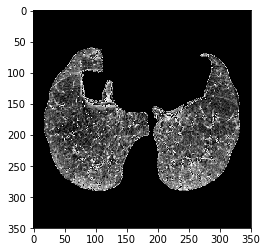

In [23]:
x = scan_segmented_lungs_fill['0c98fcb55e3f36d0c2b6507f62f4c5f1'][100]
plt.imshow(x, interpolation='nearest')
plt.show()

(335, 2048)


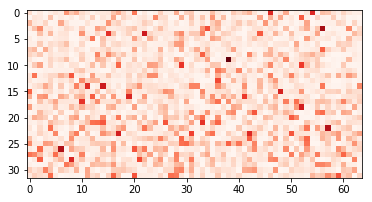

In [26]:
y = np.load("/kaggle/dev/data-science-bowl-2017-data/CIFAR-10/cache/inception_cifar10_7852cb521d7029ca08133476054e7bec.pkl")
print(y.shape)
img = y[100]
img = img.reshape((32, 64))

# Plot the image for the transfer-values.
plt.imshow(img, interpolation='nearest', cmap='Reds')
plt.show()